### Q. Can we compare scores of various scikit learn models using visual diagostic tool **yellowbrick** and select best model out of it
Ans --> Yes

**The model selection triple** was first described in a 2015 SIGMOD paper by Kumar et al. In their paper, which concerns the development of next-generation database systems built to anticipate predictive modeling, the authors cogently express that such systems are badly needed due to the highly experimental nature of machine learning in practice. “Model selection,” they explain, “is iterative and exploratory because the space of [model selection triples] is usually infinite, and it is generally impossible for analysts to know a priori which [combination] will yield satisfactory accuracy and/or insights.”

Recently, much of this workflow has been automated through grid search methods, standardized APIs, and GUI-based applications. In practice, however, human intuition and guidance can more effectively hone in on quality models than exhaustive search. By visualizing the model selection process, data scientists can steer towards final, explainable models and avoid pitfalls and traps.

The Yellowbrick library is a diagnostic visualization platform for machine learning that allows data scientists to steer the model selection process. Yellowbrick extends the Scikit-Learn API with a new core object: the Visualizer. Visualizers allow visual models to be fit and transformed as part of the Scikit-Learn Pipeline process, providing visual diagnostics throughout the transformation of high dimensional data.

We are going to use mushrooms data from the Yellowbrick Example Datasets module. Our objective is to predict if a mushroom is poisonous or edible based on its characteristics.

**About Mushroom dataset:-**
- The data include descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species was identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended (this latter class was combined with the poisonous one).

- Our data contains information for 3 nominally valued attributes and a target value from 8124 instances of mushrooms (4208 edible, 3916 poisonous).

In [2]:
from yellowbrick.datasets import load_mushroom
X, y = load_mushroom()

In [4]:
X.head()

,shape,surface,color
0,convex,smooth,yellow
1,bell,smooth,white
2,convex,scaly,white
3,convex,smooth,gray
4,convex,scaly,yellow


In [5]:
y.head()

0       edible
1       edible
2    poisonous
3       edible
4       edible
Name: target, dtype: object

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   shape    8123 non-null   object
 1   surface  8123 non-null   object
 2   color    8123 non-null   object
dtypes: object(3)
memory usage: 190.5+ KB


In [9]:
y.value_counts()

edible       4208
poisonous    3915
Name: target, dtype: int64

## Modeling and Evaluation

#### Common metrics for evaluating classifiers

**Precision** is the number of correct positive results divided by the number of all positive results (e.g. How many of the mushrooms we predicted would be edible actually were?).

**Recall** is the number of correct positive results divided by the number of positive results that should have been returned (e.g. How many of the mushrooms that were poisonous did we accurately predict were poisonous?).

The **F1 score** is a measure of a test’s accuracy. It considers both the precision and the recall of the test to compute the score. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0.

In [21]:
# precision = true positives / (true positives + false positives)

# recall = true positives / (false negatives + true positives)

# F1 score = 2 * ((precision * recall) / (precision + recall))

# Feature Extraction & modeling

Our data, including the target, is categorical. We will need to change these values to numeric ones for machine learning. In order to extract this from the dataset, we’ll have to use scikit-learn transformers to transform our input dataset into something that can be fit to a model. Luckily, scikit-learn does provide transformers for converting categorical labels into numeric integers: sklearn.preprocessing.LabelEncoder and sklearn.preprocessing.OneHotEncoder.

We’ll use a combination of scikit-learn’s Pipeline object OneHotEncoder, and LabelEncoder:

In [19]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings(action='ignore')

models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]

def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    
    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder()),
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

for model in models:
    score_model(X, y, model)
    


SVC: 0.6624286455630514
NuSVC: 0.6726016476215785
LinearSVC: 0.6583804143126177
SGDClassifier: 0.6192850021364478
KNeighborsClassifier: 0.6581185045215279
LogisticRegression: 0.6580434509606933
LogisticRegressionCV: 0.6583804143126177
BaggingClassifier: 0.7097661623108665
ExtraTreesClassifier: 0.6871364804544838
RandomForestClassifier: 0.6871364804544838


#### Based on the results from the F1 scores above, which model is performing the best?

## Visual Model Evaluation

Now let’s refactor our model evaluation function to use Yellowbrick’s ClassificationReport class, a model visualizer that displays the precision, recall, and F1 scores. This visual model analysis tool integrates numerical scores as well as color-coded heatmaps in order to support easy interpretation and detection, particularly the nuances of Type I and Type II error, which are very relevant (lifesaving, even) to our use case!

Type I error (or a “false positive”) is detecting an effect that is not present (e.g. determining a mushroom is poisonous when it is in fact edible).

Type II error (or a “false negative”) is failing to detect an effect that is present (e.g. believing a mushroom is edible when it is in fact poisonous).

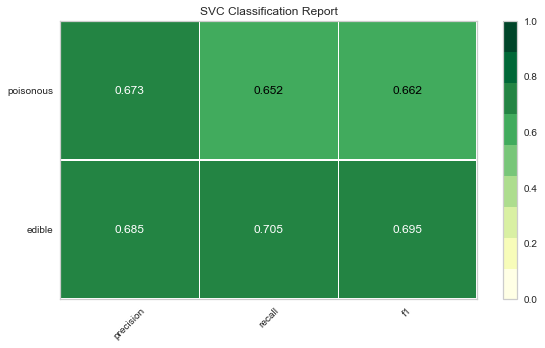

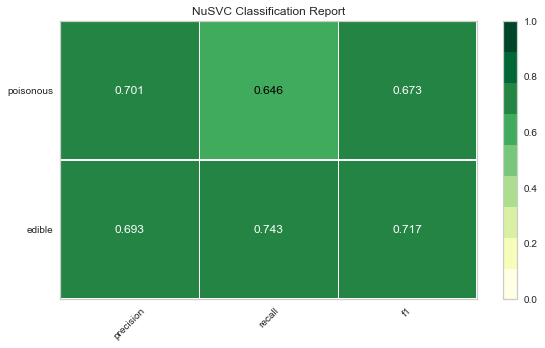

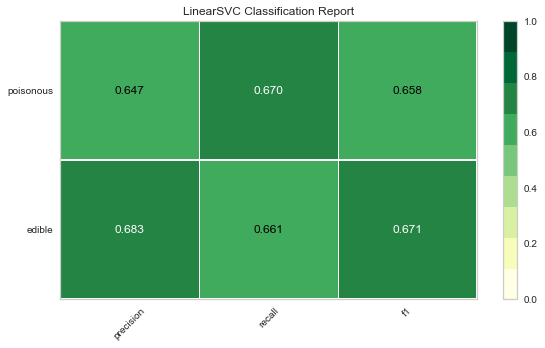

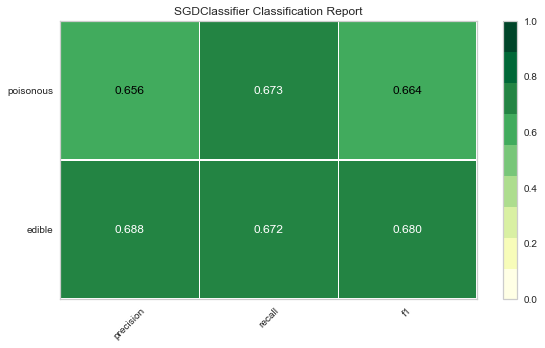

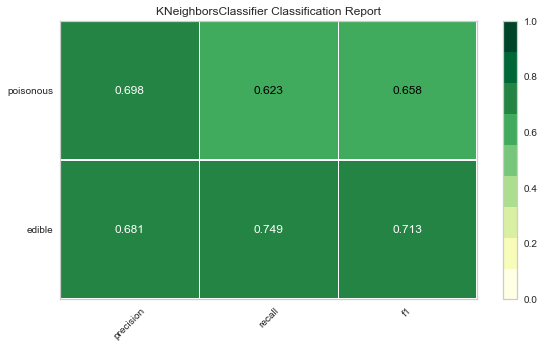

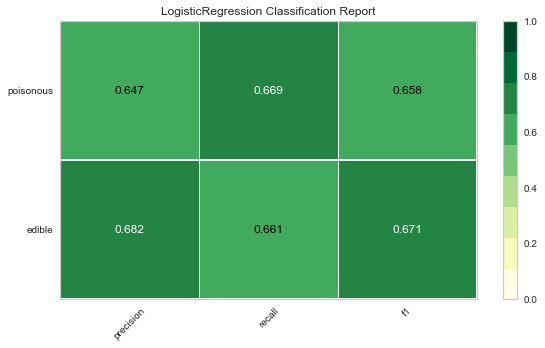

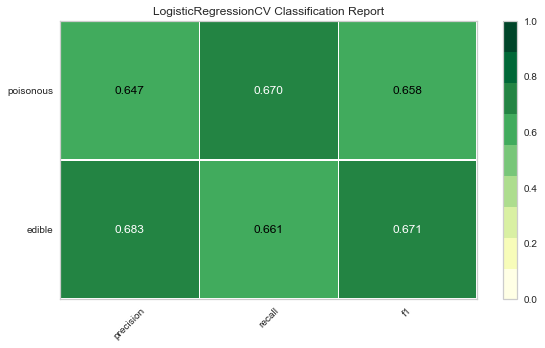

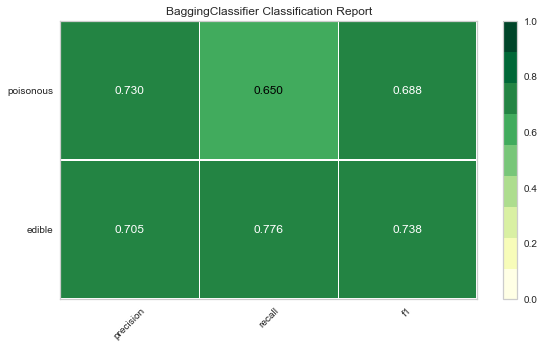

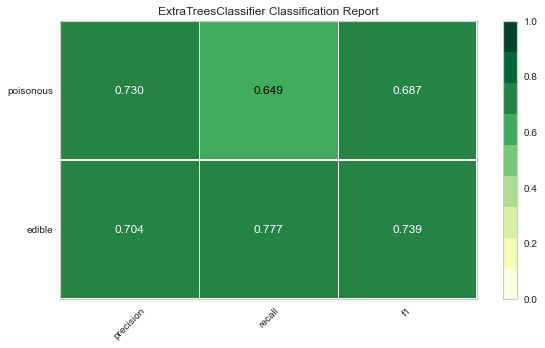

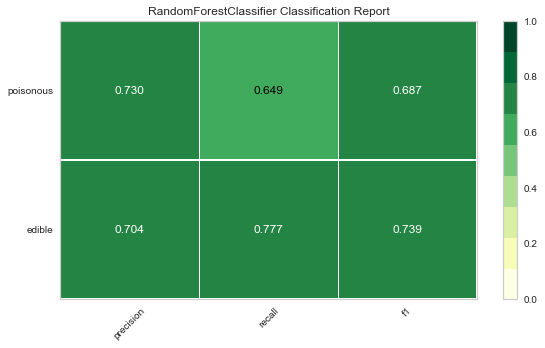

In [20]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder()),
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['edible', 'poisonous'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

for model in models:
    visualize_model(X, y, model)